In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from scripts.utils import *
from scripts.models import *
import warnings
warnings.filterwarnings("ignore")
  
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

/home/ubuntu/anaconda3/envs/rapids/lib/python3.8/site-packages/snowflake/connector/options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (5.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  warn_incompatible_dep(
2022-02-17 20:15:51.322763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 20:15:51.323301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 20:15:51.323505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Load dataframes
data_version = 13
dataset = 'upmc'
upmc_test_coverslip = 'c005'
upmc_cell_labels = get_labels('upmc')
run_name = [
            '1012_7c_ca',
            '1130_upmc_cv1',
            '1130_upmc_cv2',
            '1130_upmc_cv3',
            '1130_upmc_cv4',
           ]
upmc_pred_cols = get_pred_cols(upmc_cell_labels)
upmc_study_id = '196a98d2-f0c1-4f22-b249-701dcbc3da84'
charville_study_id = '5a987988-a392-452f-9e3d-2e5625498768'

train_on_one_coverslip = True
cell_exp_df = pd.read_parquet('dfs/UPMC/alex_norm_exp_df.pqt')
upmc_biomarkers = get_biomarkers('upmc')
char_biomarkers = get_biomarkers('charville')

seven_biomarkers = get_top_biomarkers(k=7)

data_df = get_pred_df(data_version, run_name)
data_df = binarize_labels(data_df, upmc_cell_labels)

# Exclude invalid cell IDs
data_df = data_df[~data_df.CELL_ID.isin([15869, 89254, 108260, 1221615])]
#data_df['ACQUISITION_ID'] = data_df['PATH'].apply(lambda x: x.split('/')[6])

full_df = data_df.merge(cell_exp_df, on="CELL_ID")

In [3]:
prefix = '/home/ubuntu/efs/dapi/data/graph/'
    
# baseline_df = pd.read_parquet('export/upmc_celltype_preds_c005_120721.pqt')
# colocal_df = pd.read_parquet('export/upmc_celltype_preds_c005_120721_w_colocal.pqt')
# char_df = pd.read_parquet('export/upmc_celltype_preds_c005_120721_w_char.pqt')
ensemble_df = pd.read_parquet('export/upmc_celltype_preds_c005_ensemble.pqt')
input_df = pd.read_parquet('export/upmc_celltype_preds_c005_7_bms.pqt')
char_df = pd.read_parquet('export/upmc_celltype_preds_on_charville.pqt')
cshn_df = pd.read_parquet('export/cshn_w_upmc_model_c004.pqt')

In [ ]:
ensemble_df

<Figure size 432x288 with 0 Axes>

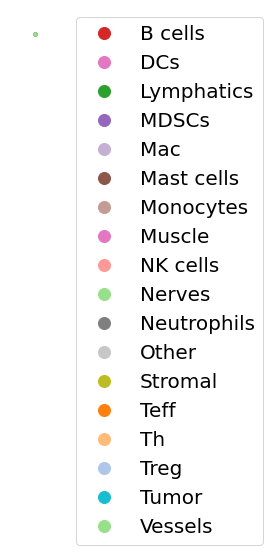

In [4]:
cshn_cell_labels = get_labels('cshn')
cshn_cell_labels
CSHN_colors = {
    'B cells': 6,
 'DCs': 12,
 'Lymphatics': 4,
 'MDSCs': 8,
 'Mac': 9 ,
 'Mast cells':  10,
 'Monocytes': 11,
 'Muscle': 12,
 'NK cells': 7,
 'Nerves': 5,
 'Neutrophils': 14,
 'Other': 15,
 'Stromal': 16,
 'Teff': 2,
 'Th': 3,
 'Treg': 1,
 'Tumor': 18,
 'Vessels': 5
}
cm = matplotlib.cm.get_cmap("tab20")
cmap_colors = {k: cm(v) for k, v in CSHN_colors.items()}

def plot_ct_legend(colors):
    cm = matplotlib.cm.get_cmap("tab20")
    plt.clf()
    fig = plt.figure(figsize=(1, 1))
    for label, num in colors.items():
        plt.plot([0], [0], '.', label=label, c=cm(num))
    #plt.plot([0], [0], '.', c='w', markersize=1)
    plt.legend(bbox_to_anchor=(1.05, 1.), prop={'size': 20}, markerscale=4.)
    plt.axis('off')
    plt.show()
plot_ct_legend(CSHN_colors)

<Figure size 432x288 with 0 Axes>

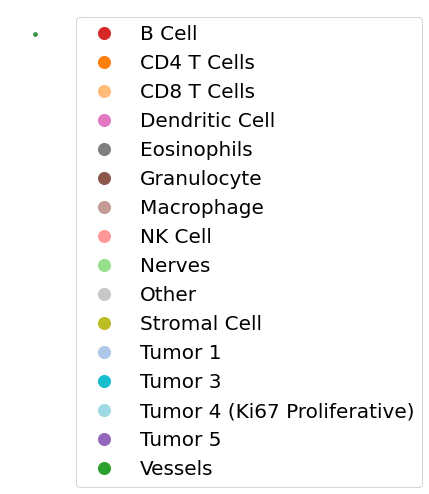

In [10]:
char_cell_labels = get_labels('charville')
char_cell_labels
Char_colors = {
    'B Cell': 6,
 'CD4 T Cells': 2,
 'CD8 T Cells': 3,
 'Dendritic Cell': 12,
 'Eosinophils': 14,
 'Granulocyte': 10,
 'Macrophage': 11,
 'NK Cell': 7,
 'Nerves': 5,
 'Other': 15,
 'Stromal Cell': 16,
 'Tumor 1': 1,
 'Tumor 3': 18,
 'Tumor 4 (Ki67 Proliferative)': 19,
 'Tumor 5': 8,
 'Vessels': 4
}
cm = matplotlib.cm.get_cmap("tab20")
cmap_colors = {k: cm(v) for k, v in Char_colors.items()}

def plot_ct_legend(colors):
    cm = matplotlib.cm.get_cmap("tab20")
    plt.clf()
    fig = plt.figure(figsize=(1, 1))
    for label, num in colors.items():
        plt.plot([0], [0], '.', label=label, c=cm(num))
    #plt.plot([0], [0], '.', c='w', markersize=1)
    plt.legend(bbox_to_anchor=(1.05, 1.), prop={'size': 20}, markerscale=4.)
    plt.axis('off')
    plt.show()
plot_ct_legend(Char_colors)

<Figure size 432x288 with 0 Axes>

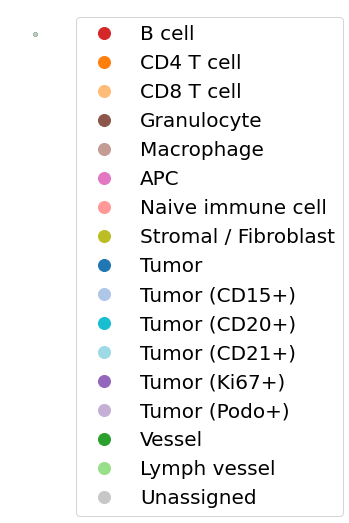

In [13]:
UPMC_colors = {
    'B cell': 6,
    'CD4 T cell': 2,
    'CD8 T cell': 3,
    'Granulocyte': 10,
    'Macrophage': 11,
    'APC': 12,
    'Naive immune cell': 7,
    'Stromal / Fibroblast': 16,
    'Tumor': 0,
    'Tumor (CD15+)': 1,
    'Tumor (CD20+)': 18,
    'Tumor (CD21+)': 19,
    'Tumor (Ki67+)': 8,
    'Tumor (Podo+)': 9,
    'Vessel': 4,
    'Lymph vessel': 5,
    'Unassigned': 15, # For matplotlib only
}
cm = matplotlib.cm.get_cmap("tab20")
cmap_colors = {k: cm(v) for k, v in UPMC_colors.items()}

def plot_ct_legend(colors):
    cm = matplotlib.cm.get_cmap("tab20")
    plt.clf()
    fig = plt.figure(figsize=(1, 1))
    for label, num in colors.items():
        plt.plot([0], [0], '.', label=label, c=cm(num))
    #plt.plot([0], [0], '.', c='w', markersize=1)
    plt.legend(bbox_to_anchor=(1.05, 1.), prop={'size': 20}, markerscale=4.)
    plt.axis('off')
    plt.show()
plot_ct_legend(UPMC_colors)

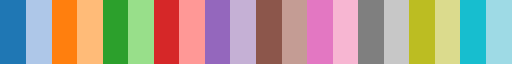

In [9]:
cm

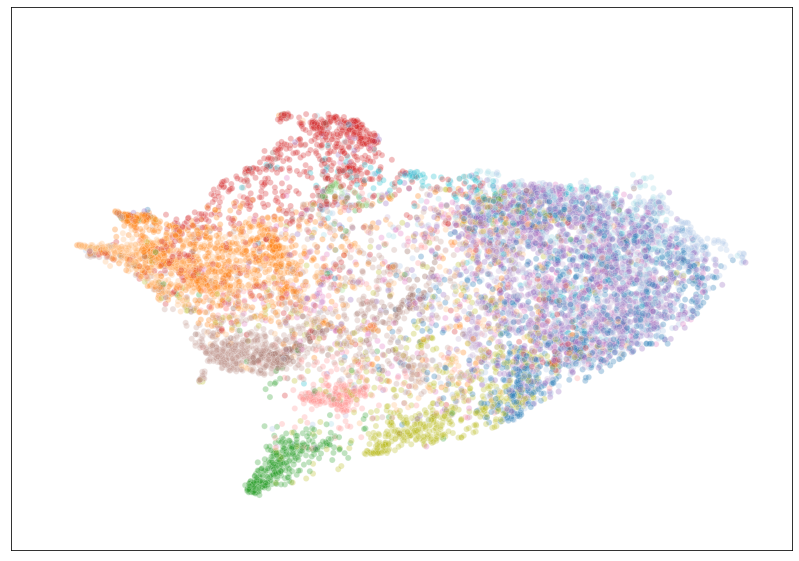

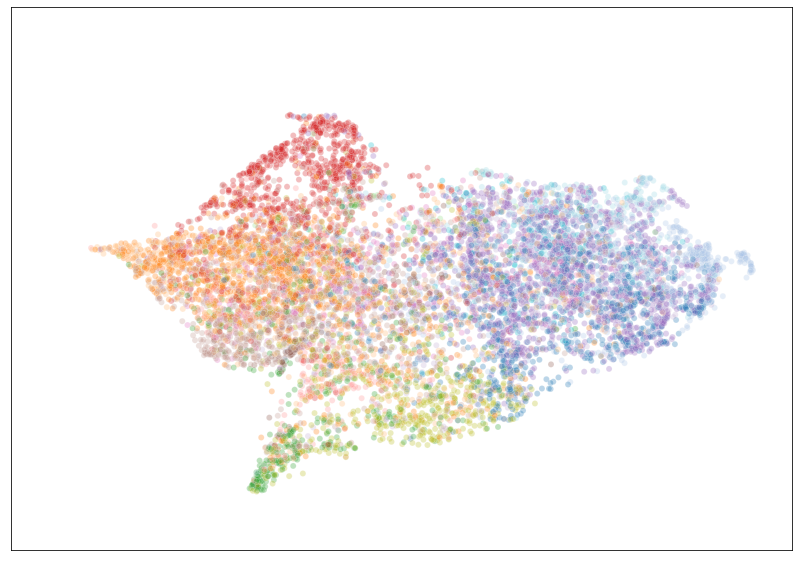

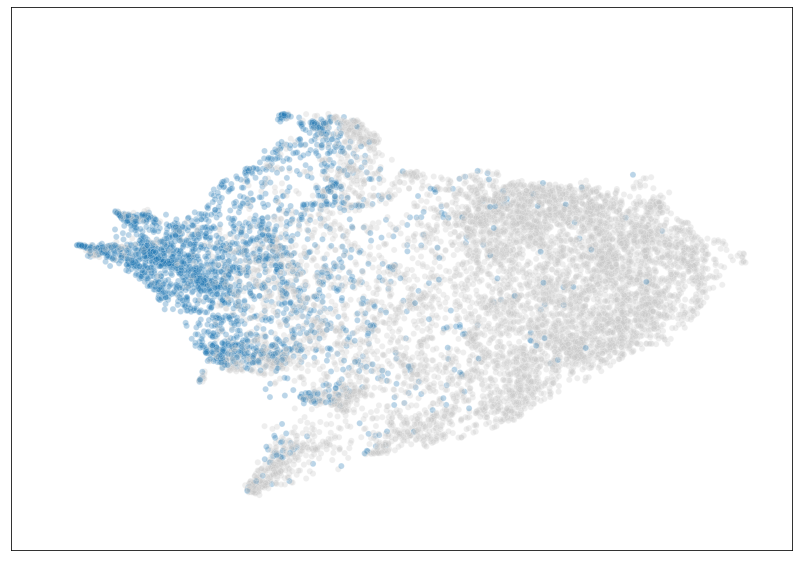

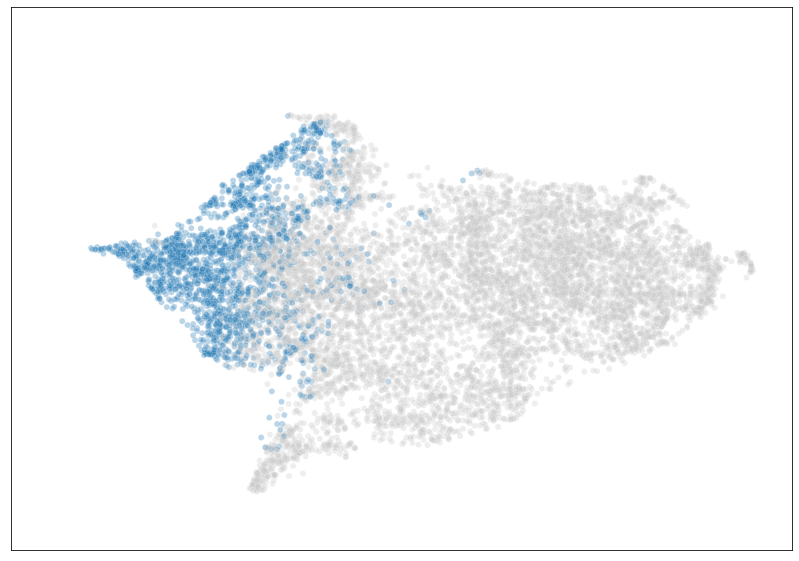

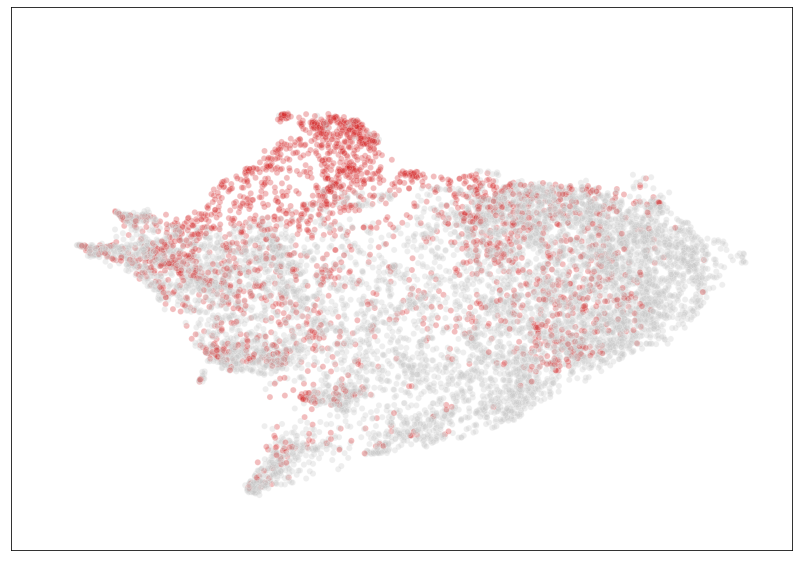

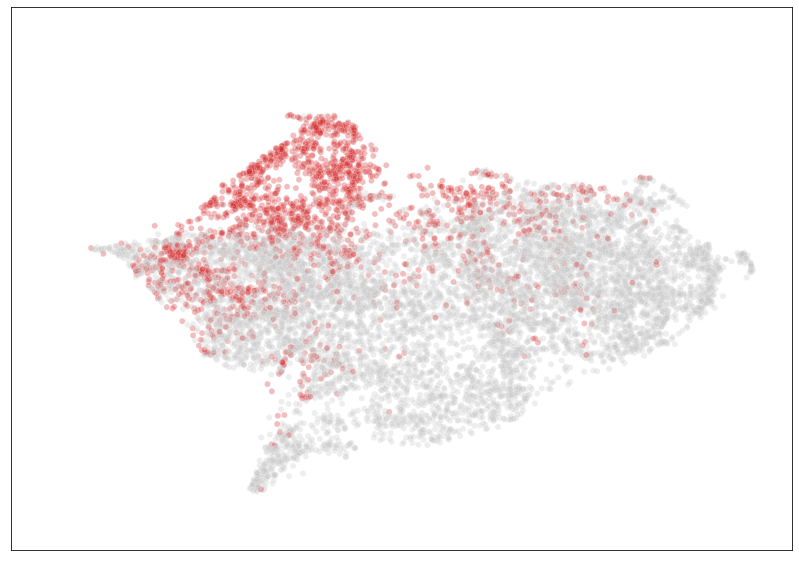

In [6]:
# Combined both imputed and real biomarkers

df = pd.DataFrame([])
upmc_imputed_biomarkers = list(set(upmc_biomarkers)-set(seven_biomarkers))

upmc_exp_pred_cols = ['{}_PRED'.format(x) for x in upmc_imputed_biomarkers]

n = 10000
bm = 'CD45'
test_df_ = full_df[full_df['split'] == 'test']
true_df = test_df_.sample(n)
pred_df = ensemble_df[(ensemble_df['CELL_ID'].isin(test_df_['CELL_ID'])) & (~ensemble_df['CELL_ID'].isin(true_df['CELL_ID']))].sample(n)
#baseline_df = input_df[(input_df['CELL_ID'].isin(test_df_['CELL_ID'])) & (~input_df['CELL_ID'].isin(true_df['CELL_ID'])) & (~input_df['CELL_ID'].isin(pred_df['CELL_ID']))].sample(n)

comb_df = pd.concat([true_df, pred_df])
comb_arr = np.concatenate((true_df[upmc_imputed_biomarkers].values, pred_df[upmc_exp_pred_cols].values), axis=0)
df[['UMAP 1', 'UMAP 2']] = cuml.UMAP(n_components=2, random_state=42).fit_transform(comb_arr)
df['Cell Label'] = comb_df['LABEL'].apply(lambda x: upmc_cell_labels[x]).values
df[bm] = comb_df[bm].apply(lambda x: int(x > comb_df[bm].quantile(.75))).values
df[bm+'_PRED'] = comb_df[bm+'_PRED'].apply(lambda x: int(x > comb_df[bm].quantile(.75))).values

colors = sns.color_palette("tab20")
 
plt.figure(figsize=(14,10))
#plt.subplot(1, 2, 1)
#plt.title("Groundtruth")
sns.scatterplot( 
    x="UMAP 1", y="UMAP 2",
    hue="Cell Label",
    hue_order = upmc_cell_labels,
    palette=cmap_colors,
    data=df.iloc[0:n],
    legend=False,
    alpha=0.3
)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

plt.figure(figsize=(14,10))

#plt.figure(figsize=(16,10))
#plt.title("Imputed")
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue="Cell Label",
    hue_order = upmc_cell_labels,
    palette=cmap_colors,
    data=df.iloc[n:2*n],
    legend=False,
    alpha=0.3
)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()


plt.figure(figsize=(14,10))

#plt.title(bm+' (true)')
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue=bm,
    hue_order = [0, 1],
    palette={0: cm(15),
         1: cm(0)},
    data=df.iloc[0:n],
    legend=False,
    alpha=0.3
)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

plt.figure(figsize=(14,10))

#plt.title(bm+' (imputed)')
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue=bm+'_PRED',
    hue_order = [0, 1],
    palette={0: cm(15),
         1: cm(0)},
    data=df.iloc[n:2*n],
    legend=False,
    alpha=0.3
)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

bm = 'CD20'

df[bm] = comb_df[bm].apply(lambda x: int(x > comb_df[bm].quantile(.75))).values
df[bm+'_PRED'] = comb_df[bm+'_PRED'].apply(lambda x: int(x > comb_df[bm].quantile(.75))).values



plt.figure(figsize=(14,10))

#plt.title(bm+' (true)')
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue=bm,
    hue_order = [0, 1],
    palette={0: cm(15),
         1: cm(6)},
    data=df.iloc[0:n],
    legend=False,
    alpha=0.3
)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

plt.figure(figsize=(14,10))

#plt.title(bm+' (imputed)')
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue=bm+'_PRED',
    hue_order = [0, 1],
    palette={0: cm(15),
         1: cm(6)},
    data=df.iloc[n:2*n],
    legend=False,
    alpha=0.3
)

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

## Image cell Visualizations

## Graph Visualizations

Get celltype F1 per acquisition ID

In [ ]:
folder = 'celltype'
df_ = ensemble_df

for idx, acq_id in enumerate([
'UPMC_c005_v001_r001_reg064',
'UPMC_c005_v001_r001_reg043',
'UPMC_c005_v001_r001_reg052',
'UPMC_c005_v001_r001_reg022',
'UPMC_c005_v001_r001_reg024',
'UPMC_c005_v001_r001_reg023',
'UPMC_c005_v001_r001_reg005',
'UPMC_c005_v001_r001_reg015',
'UPMC_c005_v001_r001_reg014',
'UPMC_c005_v001_r001_reg059',
'UPMC_c005_v001_r001_reg050',
'UPMC_c005_v001_r001_reg044',
'UPMC_c005_v001_r001_reg016',
'UPMC_c005_v001_r001_reg049',
'UPMC_c005_v001_r001_reg021',
'UPMC_c005_v001_r001_reg025',
'UPMC_c005_v001_r001_reg054',
'UPMC_c005_v001_r001_reg007',
'UPMC_c005_v001_r001_reg035',
'UPMC_c005_v001_r001_reg056',
'UPMC_c005_v001_r001_reg019'
                  ]):
    print(acq_id)
    fn = 'images/{}/{}.png'.format(folder, acq_id)
    os.makedirs('images/{}'.format(folder), exist_ok=True)
    img = get_segmask_from_acq_id(study_id='196a98d2-f0c1-4f22-b249-701dcbc3da84', acq_id=acq_id)
    img_true = np.ones_like(img, dtype=np.float32)*-1
    img_pred = np.ones_like(img, dtype=np.float32)*-1
    for i, row in df_[df_['CELL_ID'].isin(np.unique(img))].iterrows():
        pixels = np.where(img == int(row['CELL_ID']))
        img_true[pixels] = UPMC_colors[upmc_cell_labels[row['LABEL_NEW']]]
        img_pred[pixels] = UPMC_colors[upmc_cell_labels[row['PRED']]]

    img_true[img_true>df_['LABEL_NEW'].max()] = -1
    img_pred[img_pred>df_['LABEL_NEW'].max()] = -1
    img_true = np.ma.masked_where(img_true == -1, img_true)
    img_pred = np.ma.masked_where(img_pred == -1, img_pred)

    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))

    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_true, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))
    plot = plt.pcolormesh(img_pred, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    #plt.savefig(fn)

In [ ]:
folder = 'celltype'
f1 = ['0.610', '0.613', '0.618']
upmc_study_id = '196a98d2-f0c1-4f22-b249-701dcbc3da84'
for idx, acq_id in enumerate(['UPMC_c005_v001_r001_reg005', 'UPMC_c005_v001_r001_reg064',
                'UPMC_c005_v001_r001_reg050',
                'UPMC_c005_v001_r001_reg057'
              ]):
    print(acq_id)
    fn = 'images/{}/{}.png'.format(folder, acq_id)
    os.makedirs('images/{}'.format(folder), exist_ok=True)
    img = get_segmask_from_acq_id(study_id=upmc_study_id, acq_id=acq_id)
    img_true = np.ones_like(img, dtype=np.float32)*-1
    img_pred = np.ones_like(img, dtype=np.float32)*-1
    for i, row in ensemble_df[ensemble_df['CELL_ID'].isin(np.unique(img))].iterrows():
        pixels = np.where(img == int(row['CELL_ID']))
        img_true[pixels] = row['LABEL_NEW']
        img_pred[pixels] = row['PRED']

    img_true[img_true>ensemble_df['LABEL_NEW'].max()] = -1
    img_pred[img_pred>ensemble_df['LABEL_NEW'].max()] = -1
    img_true = np.ma.masked_where(img_true == -1, img_true)
    img_pred = np.ma.masked_where(img_pred == -1, img_pred)

    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0] * 2, 10))
    #print(acq_id)

    #pdb.set_trace()
    #GROUNDTRUTH
    plt.subplot(1, 2, 1)
    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
#     sns.heatmap(img_true, cmap=cmap, vmin=0, vmax=cmap.N)
    plot = plt.pcolormesh(img_true, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("Groundtruth".format(acq_id))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_pred, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("Predicted (F1: {})".format(f1[idx]))
    
    plt.xticks([])
    plt.yticks([])    
    
    plt.show()
    plt.savefig(fn)

## Charville

Charville_c004_v001_r001_reg139
Loading existing...


<Figure size 432x288 with 0 Axes>

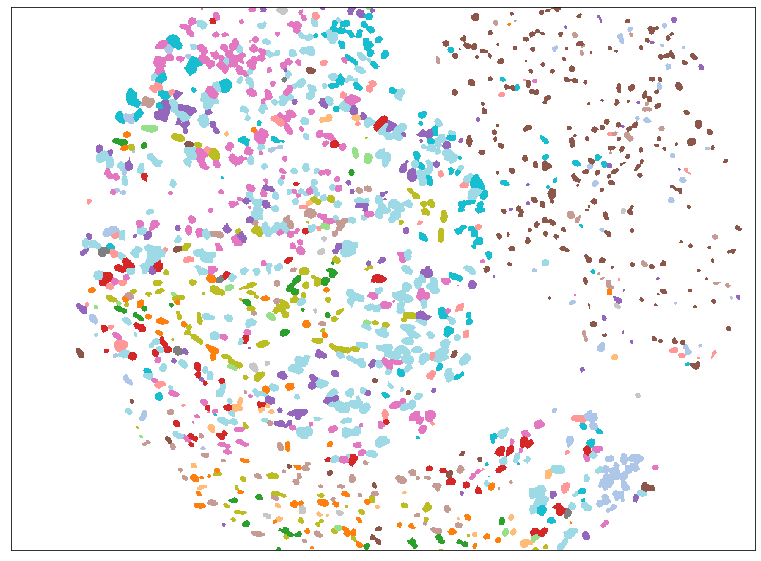

<Figure size 432x288 with 0 Axes>

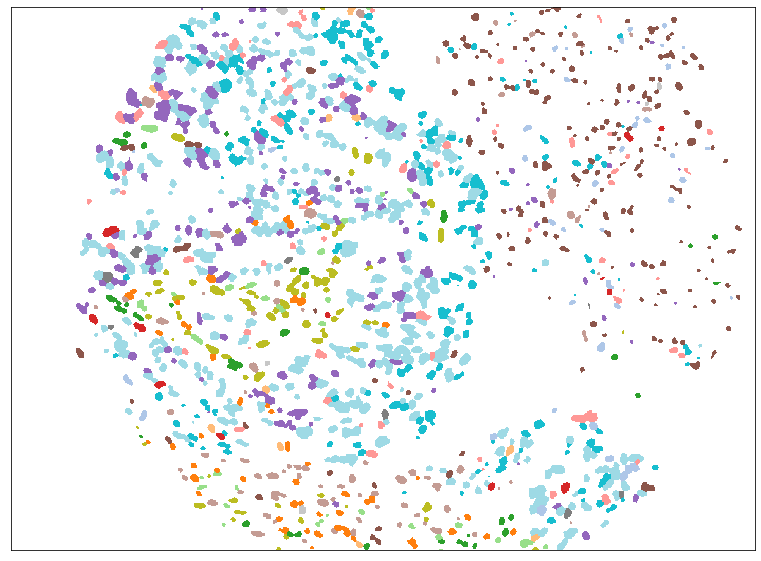

In [13]:
folder = 'celltype'
f1 = ['0.610', '0.613', '0.618']
upmc_study_id = '196a98d2-f0c1-4f22-b249-701dcbc3da84'
char_study_id = '5a987988-a392-452f-9e3d-2e5625498768'
# for idx, acq_id in enumerate(['UPMC_c005_v001_r001_reg064',
#                 'UPMC_c005_v001_r001_reg050',
#                 'UPMC_c005_v001_r001_reg057'
#               ]):
for idx, acq_id in enumerate(['Charville_c004_v001_r001_reg139']):
    print(acq_id)
    char_df_ = char_df[char_df['ACQUISITION_ID'] == acq_id]
    char_df_['CELL_ID'] = char_df_['CELL_ID'].apply(lambda x: int(float(x.split('_')[-1])))
    fn = 'images/{}/{}.png'.format(folder, acq_id)
    os.makedirs('images/{}'.format(folder), exist_ok=True)
    img = get_segmask_from_acq_id(study_id=char_study_id, acq_id=acq_id)
    img_true = np.ones_like(img, dtype=np.float32)*-1
    img_pred = np.ones_like(img, dtype=np.float32)*-1
    for i, row in char_df_[char_df_['CELL_ID'].isin(np.unique(img))].iterrows():
        pixels = np.where(img == int(row['CELL_ID']))
        img_true[pixels] = Char_colors[char_cell_labels[row['LABEL_NEW']]]
        img_pred[pixels] = Char_colors[char_cell_labels[row['PRED']]]

#     img_true[img_true>char_df_['LABEL_NEW'].max()] = -1
#     img_pred[img_pred>char_df_['LABEL_NEW'].max()] = -1
    img_true = np.ma.masked_where(img_true == -1, img_true)
    img_pred = np.ma.masked_where(img_pred == -1, img_pred)

    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))

    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_true, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))
    #plt.subplot(1, 2, 2)
    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_pred, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    #plt.savefig(fn)

CellSight_c004_v001_r001_reg003
Loading existing...


<Figure size 432x288 with 0 Axes>

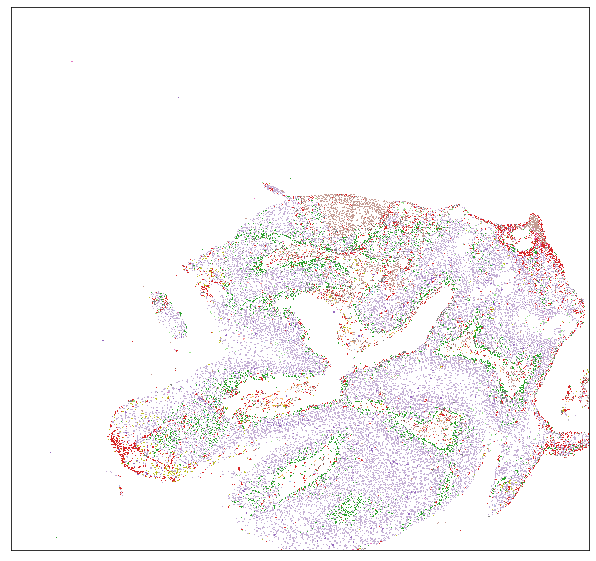

<Figure size 432x288 with 0 Axes>

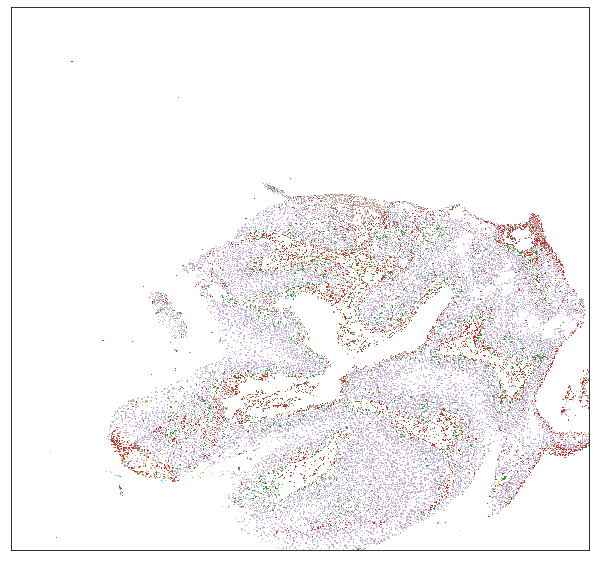

CellSight_c004_v001_r001_reg004
Loading existing...


<Figure size 432x288 with 0 Axes>

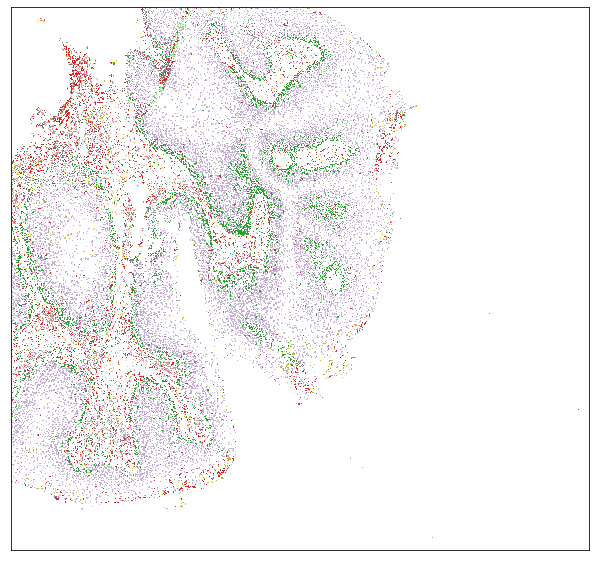

<Figure size 432x288 with 0 Axes>

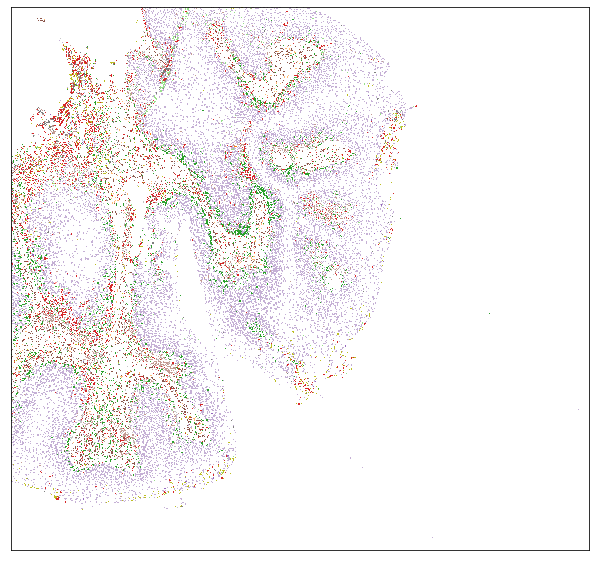

CellSight_c004_v001_r001_reg005
Loading existing...


In [ ]:
folder = 'celltype'
import scipy.sparse as sp

cshn_study_id = 'ea8c0519-5cc6-4d77-af93-9b26ad9f398c'
for idx, acq_id in enumerate(['CellSight_c004_v001_r001_reg003',
       'CellSight_c004_v001_r001_reg004',
       'CellSight_c004_v001_r001_reg005',
       'CellSight_c004_v001_r001_reg006']):
    print(acq_id)
    cshn_df_ = cshn_df[cshn_df['ACQUISITION_ID'] == acq_id]
#     cshn_df_['CELL_ID'] = cshn_df_['CELL_ID'].apply(lambda x: int(float(x.split('_')[-1])))
    fn = 'images/{}/{}.png'.format(folder, acq_id)
    os.makedirs('images/{}'.format(folder), exist_ok=True)
    img = get_segmask_from_acq_id(study_id=cshn_study_id, acq_id=acq_id)
    img_sparse = sp.csr_matrix(img)
    img_true = np.ones_like(img, dtype=np.float32)*-1
    img_pred = np.ones_like(img, dtype=np.float32)*-1
    for i, row in cshn_df_[cshn_df_['CELL_ID'].isin(np.unique(img))].iterrows():
        pixels = sp.find(img_sparse == int(row['CELL_ID']))[0:2]#np.where(img == int(row['CELL_ID']))

        img_true[pixels] = CSHN_colors[cshn_cell_labels[row['LABEL_NEW']]]
        img_pred[pixels] = CSHN_colors[cshn_cell_labels[row['PRED']]]

    img_true[img_true>20] = -1
    img_pred[img_pred>20] = -1
    img_true = np.ma.masked_where(img_true == -1, img_true)
    img_pred = np.ma.masked_where(img_pred == -1, img_pred)

    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))

    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_true, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    x_size = img_true.shape[1]
    y_size = img_true.shape[0]
    size = (x_size, y_size)
    
    plt.clf()
    plt.figure(figsize=(10/size[1] * size[0], 10))
    #plt.subplot(1, 2, 2)
    cmap = matplotlib.cm.tab20
    cmap.set_bad('white', -1)
    plot = plt.pcolormesh(img_pred, cmap=cmap, vmin=0, vmax=cmap.N)
    plt.title("")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    #plt.savefig(fn)

Loading existing...
UPMC_c005_v001_r001_reg007


<Figure size 432x288 with 0 Axes>

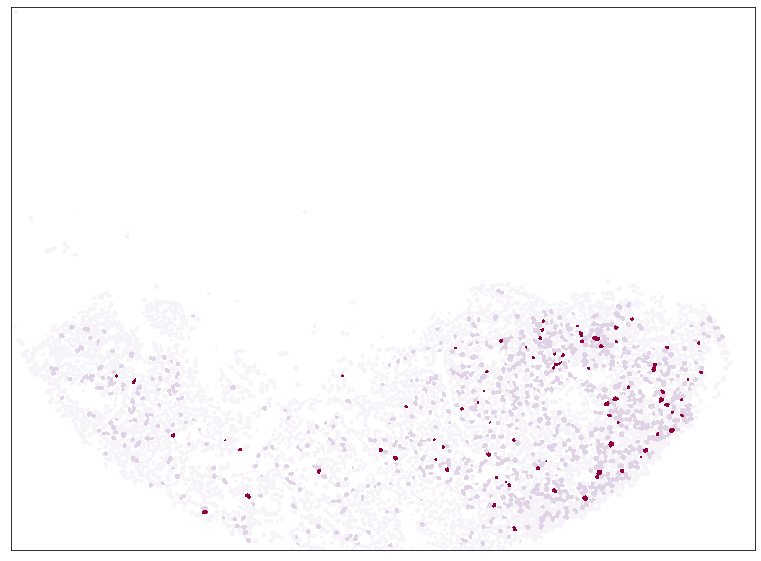

<Figure size 432x288 with 0 Axes>

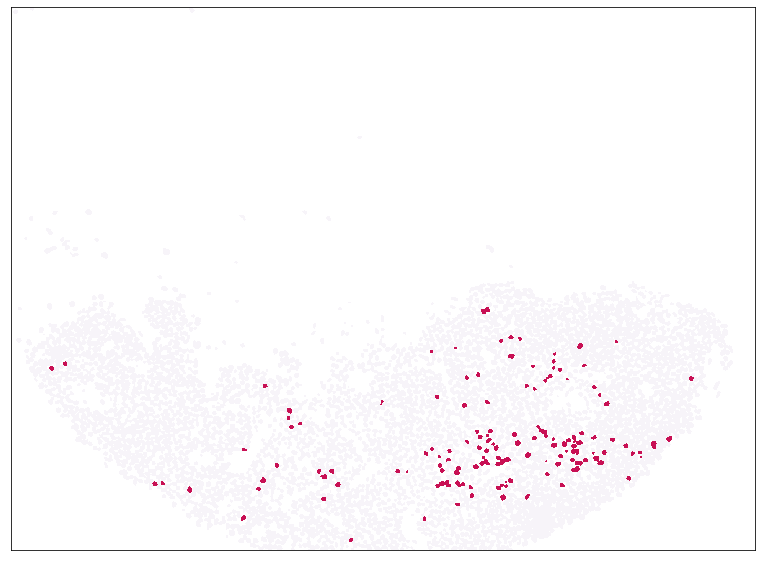

Loading existing...
UPMC_c005_v001_r001_reg030


<Figure size 432x288 with 0 Axes>

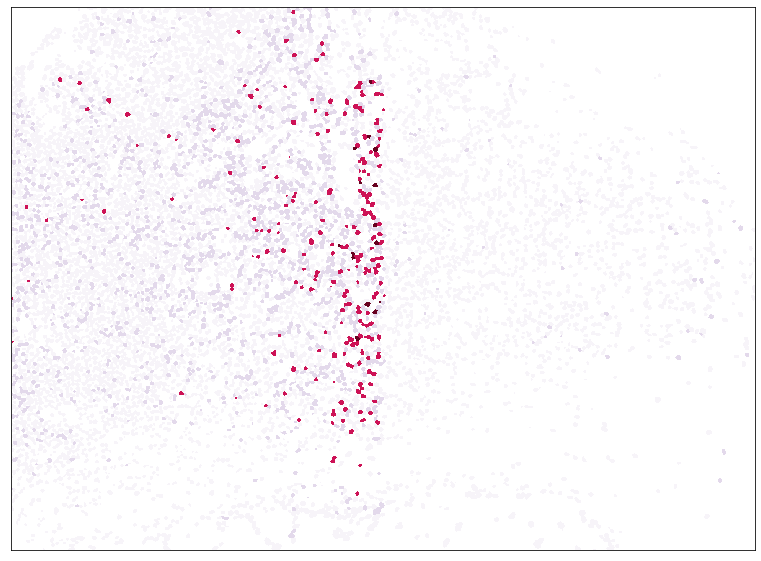

<Figure size 432x288 with 0 Axes>

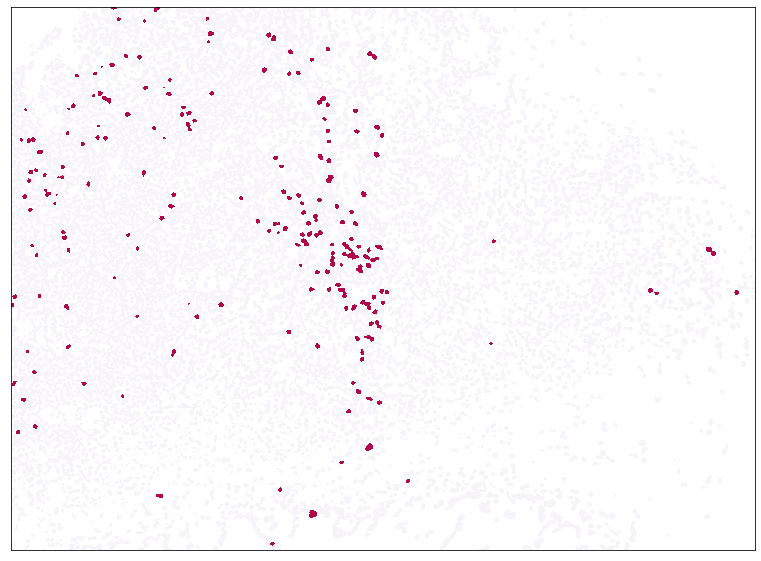

Loading existing...
UPMC_c005_v001_r001_reg028


<Figure size 432x288 with 0 Axes>

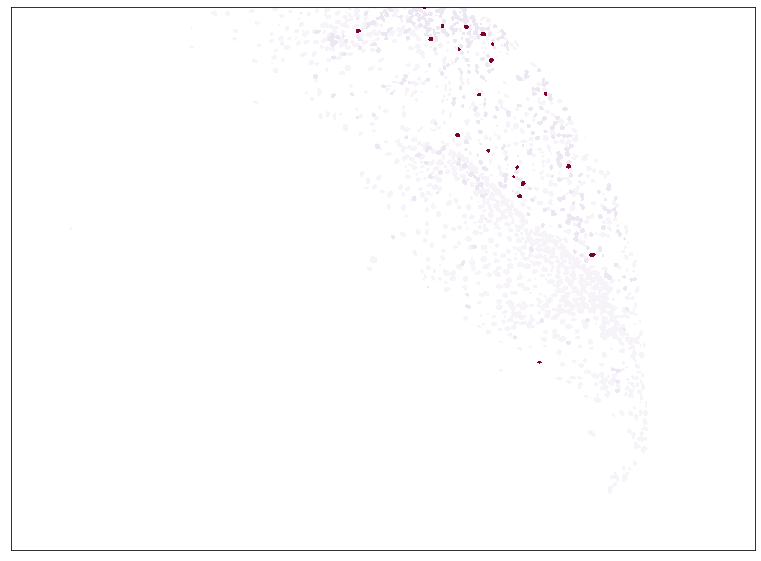

<Figure size 432x288 with 0 Axes>

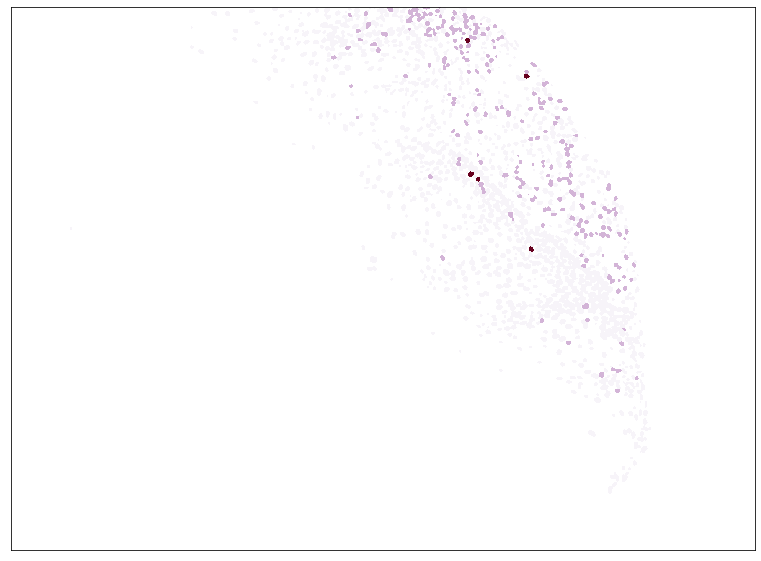

Loading existing...
UPMC_c005_v001_r001_reg006


<Figure size 432x288 with 0 Axes>

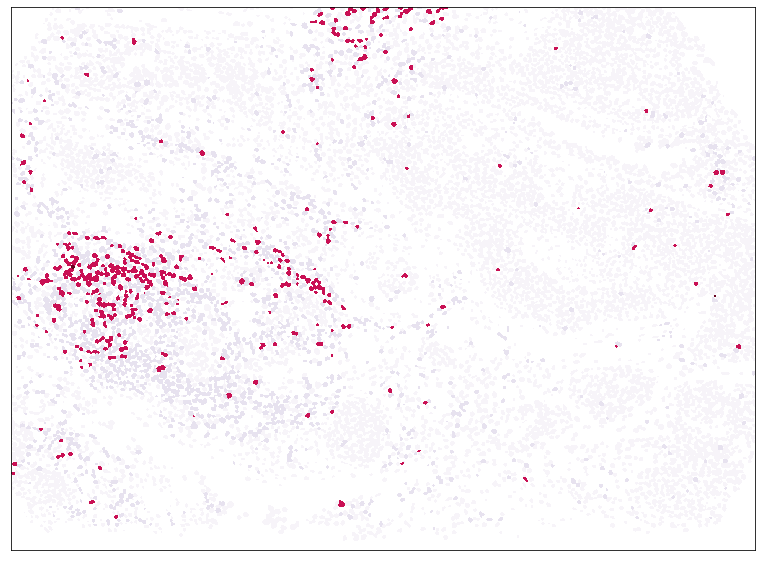

<Figure size 432x288 with 0 Axes>

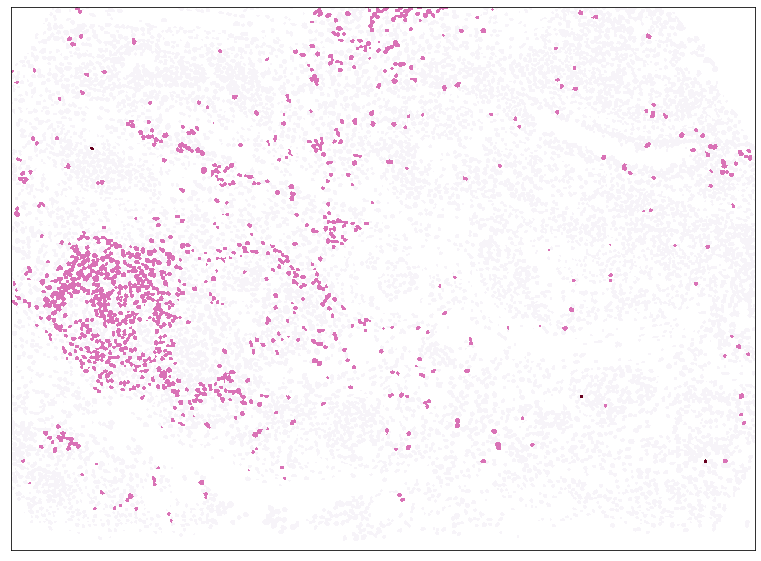

Loading existing...
UPMC_c005_v001_r001_reg021


<Figure size 432x288 with 0 Axes>

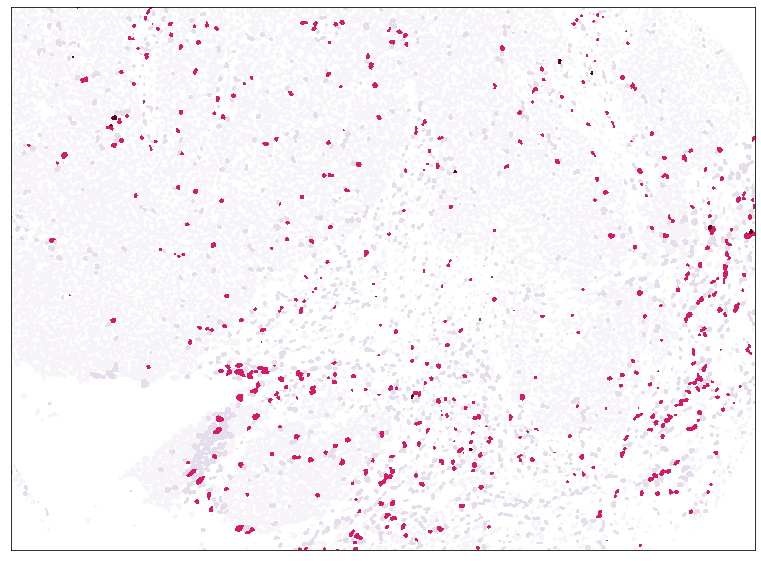

<Figure size 432x288 with 0 Axes>

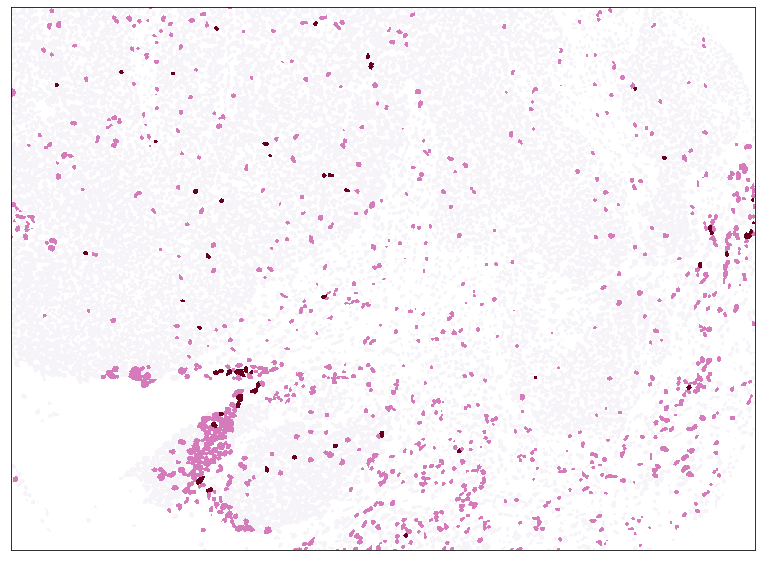

Loading existing...
UPMC_c005_v001_r001_reg035


<Figure size 432x288 with 0 Axes>

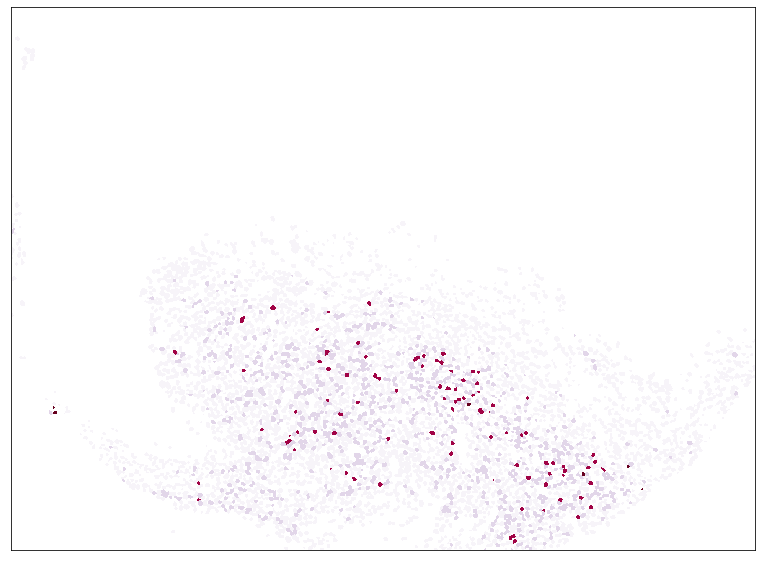

<Figure size 432x288 with 0 Axes>

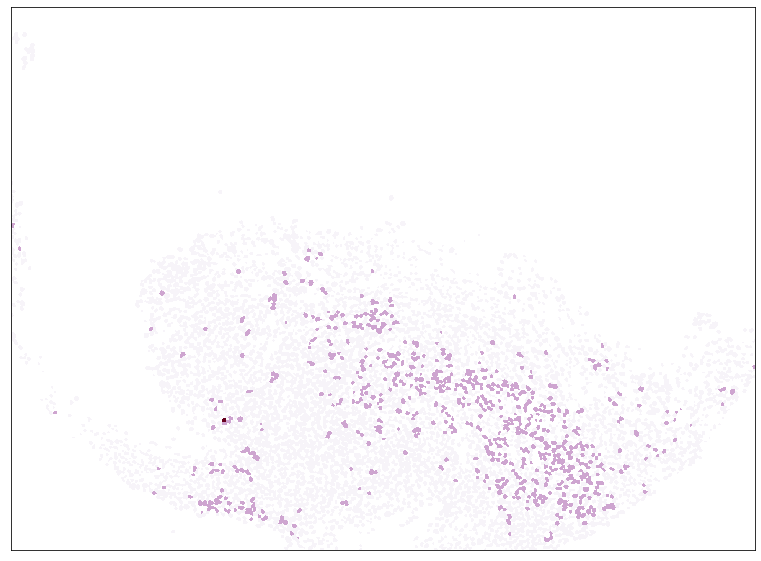

Loading existing...
UPMC_c005_v001_r001_reg022


<Figure size 432x288 with 0 Axes>

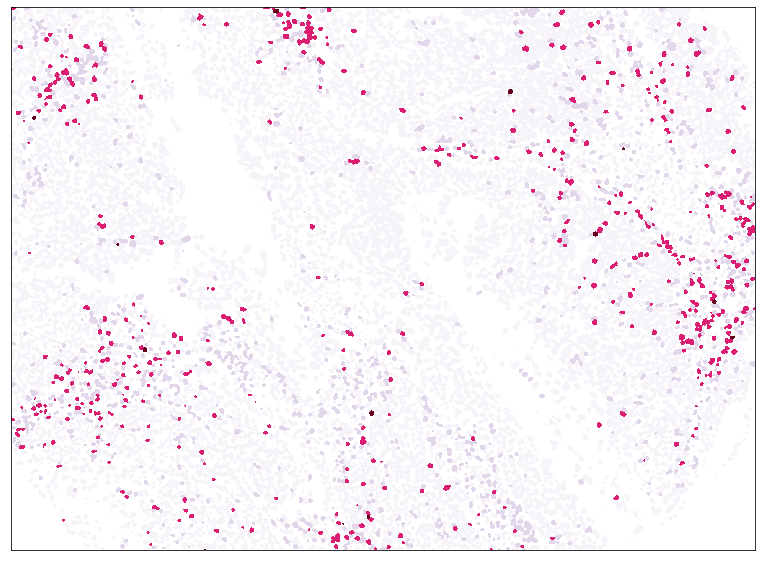

<Figure size 432x288 with 0 Axes>

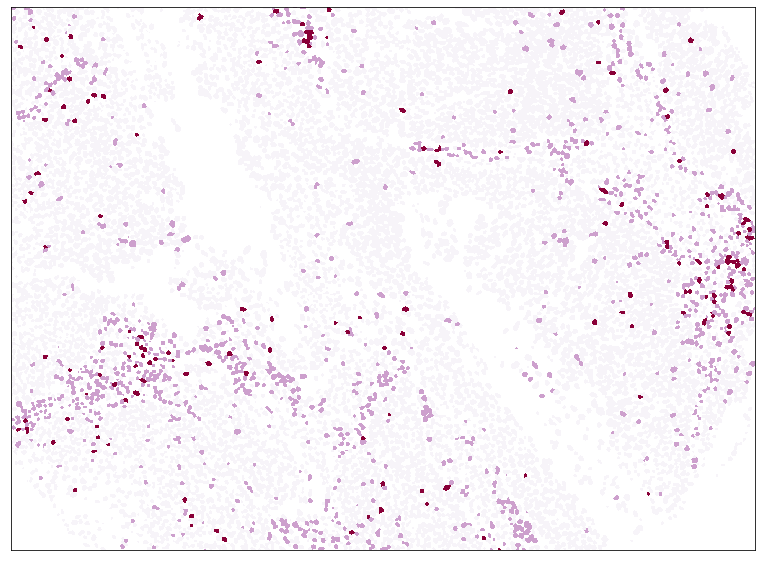

In [14]:
#for acq_id in ensemble_df['ACQUISITION_ID'].unique():
#biomarker = ['aSMA', 'CD8', 'CD20']
folder = 'exp'
for acq_id in ['UPMC_c005_v001_r001_reg007',
                'UPMC_c005_v001_r001_reg030',
                'UPMC_c005_v001_r001_reg028',
                'UPMC_c005_v001_r001_reg006',
                'UPMC_c005_v001_r001_reg021',
                'UPMC_c005_v001_r001_reg035',
                'UPMC_c005_v001_r001_reg022']:
    for color_idx, biomarker in enumerate(['CD45']):
        min_val = ensemble_df[ensemble_df.ACQUISITION_ID == acq_id][biomarker].quantile(0.75)
        max_val = ensemble_df[ensemble_df.ACQUISITION_ID == acq_id][biomarker].quantile(0.99)
        min_pred_val = ensemble_df[ensemble_df.ACQUISITION_ID == acq_id][biomarker+'_PRED'].quantile(0.75)
        max_pred_val = ensemble_df[ensemble_df.ACQUISITION_ID == acq_id][biomarker+'_PRED'].quantile(0.99)
        img = get_segmask_from_acq_id(study_id='196a98d2-f0c1-4f22-b249-701dcbc3da84', acq_id=acq_id)
        img_true = np.ones_like(img, dtype=np.int)*-1
        img_pred = np.ones_like(img, dtype=np.int)*-1
        for i, row in ensemble_df[ensemble_df['CELL_ID'].isin(np.unique(img))].iterrows():
            pixels = np.where(img == int(row['CELL_ID']))
            img_true[pixels] = row[biomarker]#np.clip(row[biomarker], min_val, max_val)#[color_mapping[int(row[biomarker] > med)]] * len(img_true[pixels])
            img_pred[pixels] = row[biomarker+'_PRED']#np.clip(row[biomarker+'_PRED'], min_val, max_val)#[color_mapping[int(row[biomarker+'_PRED'] > med)]] * len(img_pred[pixels])
        img_true[img_true>100] = -1
        img_pred[img_pred>100] = -1
        img_true = np.ma.masked_where(img_true == -1, img_true)
        img_pred = np.ma.masked_where(img_pred == -1, img_pred)
    
        plt.clf()
        size = 10
        x_size = img_true.shape[1]
        y_size = img_true.shape[0]
        plt.figure(figsize=(size/y_size * x_size, size))
        print(acq_id)

        cmap = matplotlib.cm.PuRd#tab20c
        cmap.set_bad(color='white')
        cmap.set_under(color=cmap(0))
        norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val, clip=False)
        plt.pcolormesh(img_true, cmap=cmap, norm=norm)
#         plt.title("Groundtruth {}: {}".format(biomarker, acq_id))
        plt.xticks([])
        plt.yticks([])
        #plt.grid(True)
        plt.show()
        
#         plt.subplot(1, 2, 2)
        plt.clf()
        plt.figure(figsize=(size/y_size * x_size, size))
        norm = matplotlib.colors.Normalize(vmin=min_pred_val, vmax=max_pred_val, clip=False)
        plt.pcolormesh(img_pred, cmap=cmap, norm=norm)
#         plt.title("Predicted {}".format(biomarker))
        plt.xticks([])
        plt.yticks([])
        #plt.grid(True)
        
        plt.show()




In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
paths = full_df['PATH'].sample(10)
for path in paths[5:6]:
    img = imageio.imread(path.format('UPMC', 'DAPI', '0'))
#     img_ = np.copy(img)
#     img_[:,:,1] = np.zeros_like(img_[:,:,1])
#     img_[:,:,2] = np.zeros_like(img_[:,:,2])
#     plt.imshow(img_, cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     img_ = np.copy(img)
#     img_[:,:,0] = np.zeros_like(img_[:,:,0])
#     img_[:,:,2] = np.zeros_like(img_[:,:,2])
#     plt.imshow(img_, cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     img_ = np.copy(img)
#     img_[:,:,1] = np.zeros_like(img_[:,:,1])
#     img_[:,:,0] = np.zeros_like(img_[:,:,0])
#     plt.imshow(img_, cmap='gray')
    plt.imshow(img)

    plt.xticks([])
    plt.yticks([])
    plt.show()
    